# Conditioning and Stability

In [1]:
import pandas as pd
import numpy as np
import sympy as sy
import scipy.linalg as scl
import numpy.linalg as npl
import scipy.stats
import matplotlib.pyplot as plt

### Problem 1

In [2]:
# Define the function
def get_condnum(A):
    sigma=scl.svd(A)[1]
    sigma_max=np.max(sigma)
    sigma_min=np.min(sigma)
    condnum = sigma_max/sigma_min
    if sigma_min==0:
        condnum = np.inf
    return condnum

# generate a square matrix with random numbers
A = np.random.random((4,4))
# Condition number using the function
cond_fn = get_condnum(A)
# Condition number using numpy.linalg.cond
cond_np = npl.cond(A)
print("Matrix A:\n", A)
print("\nCondition numberb of the Matrix A \nFrom function:", cond_fn, "| From numpy.linalg.cond:", cond_np)

Q = scl.qr(A)[0]
print("\nCondition of the orthonormal matrix is", get_condnum(Q))

Matrix A:
 [[0.392791   0.2431543  0.17343724 0.14621978]
 [0.82457805 0.62288312 0.15265758 0.1789407 ]
 [0.4387213  0.84251003 0.54132504 0.16689865]
 [0.04809929 0.165812   0.07732808 0.75273987]]

Condition numberb of the Matrix A 
From function: 16.137490399048833 | From numpy.linalg.cond: 16.137490399048843

Condition of the orthonormal matrix is 1.0000000000000004


### Problem 2

Absolute condition number:  3.53050945515277e-9
Relative condition number:  2436715216.34429


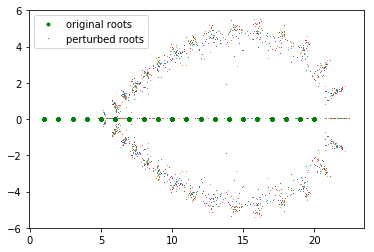

In [3]:
# Define the function
def per_wilk():
    k_hat = []
    k_rel = []
    for i in range(100):
        w_roots = np.arange(1,21)
        x,i = sy.symbols('x i')
        w = sy.poly_from_expr(sy.product(x-i, (i,1,20)))[0]
        w_coeffs = np.array(w.all_coeffs())
        r = np.random.normal(loc=1, scale=10**-10, size=len(w_coeffs))
        w_coeffs_new = w_coeffs*r
        w_roots_new = np.roots(np.poly1d(w_coeffs_new))
        w_roots = np.sort(w_roots)
        w_roots_new = np.sort(w_roots_new)
        w_roots_real = np.real(w_roots)
        w_roots_imag = np.imag(w_roots)
        w_roots_new_real = np.real(w_roots_new)
        w_roots_new_imag = np.imag(w_roots_new)
        h = w_coeffs - w_coeffs_new
        k_hat.append(scipy.linalg.norm(w_roots_new - w_roots, np.inf)/scipy.linalg.norm(h, np.inf))
        k_rel.append(k_hat[-1]*scipy.linalg.norm(w_coeffs, np.inf)/scipy.linalg.norm(w_roots, np.inf))
        plt.plot(w_roots_real, w_roots_imag, 'g.')
        plt.plot(w_roots_new_real, w_roots_new_imag, ',')
    plt.plot(w_roots_real, w_roots_imag, 'g.', label='original roots')
    plt.plot(w_roots_new_real, w_roots_new_imag, ',', label='perturbed roots')
    k_hat.append(scipy.linalg.norm(w_roots_new - w_roots, np.inf)/scipy.linalg.norm(h, np.inf))
    k_rel.append(k_hat[-1]*scipy.linalg.norm(w_coeffs, np.inf)/scipy.linalg.norm(w_roots, np.inf))
    print("Absolute condition number: ", np.mean(k_hat))
    print("Relative condition number: ", np.mean(k_rel))
    plt.legend()
    plt.show()

# Call the function 
per_wilk()

### Problem 3

In [4]:
# Define the function
def get_condeig(A):
    reals = np.random.normal(0, 1e-10, A.shape)
    imags = np.random.normal(0, 1e-10, A.shape)
    H = reals + 1j*imags
    A_new = A + H
    lamda = scl.eigvals(A)
    lamda_t = scl.eigvals(A_new)
    numertor = scl.norm(lamda - lamda_t, 2)
    denominator = scl.norm(H, 2)
    k_hat = numertor/denominator
    k_rel = k_hat*(scipy.linalg.norm(A,2)/scipy.linalg.norm(lamda,2))
    return k_hat,k_rel

# Generate A
A=np.random.random((4,4))
k_hat,k_rel = get_condeig(A)
print("Absolute condition number: ", k_hat, "| Relative condition number: ", k_rel)

Absolute condition number:  0.30370337305230266 | Relative condition number:  0.2966676012338142


### Problem 4

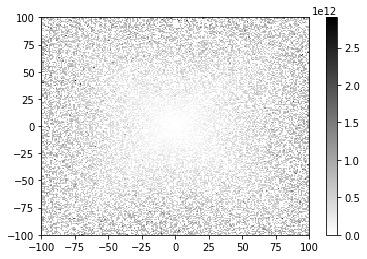

In [5]:
# Define the function to create vectors for colormap
def get_condmap(xmin, xmax, ymin, ymax, res):
    x= np.linspace(xmin, xmax, res)
    y= np.linspace(ymin, ymax, res)
    x_plot,y_plot = np.meshgrid(x,y)
    k = np.empty((len(x), len(y)))
    for i,value1 in enumerate(x):
        for j,value2 in enumerate(y):
            A = np.array([1,value1,value2,1]).reshape(2,2)
            k[i,j]=get_condeig(A)[1]
    return k,x_plot,y_plot
# Call the function with 
res = 200
k,x_plot,y_plot = get_condmap(-100, 100, -100, 100, res)
plt.pcolormesh(x_plot, y_plot, k, cmap='gray_r')
plt.colorbar()
plt.show()

### Problem 5

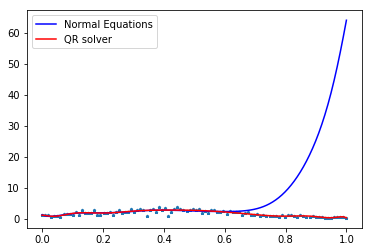

The forward errors are:  152.14373083729365 , 5.4330612351913444e-08


In [6]:
def stability(n):
    xk,yk = np.load('stability_data.npy').T
    A = np.vander(xk, n+1)
    b = yk
    sol1 = scipy.linalg.inv(A.T@A)@A.T@b
    Q,R = scl.qr(A, mode='economic')
    A1 = R
    b1 = Q.T@b
    sol2 = scl.solve_triangular(A1,b1)
    f1 = np.poly1d(sol1)
    f2 = np.poly1d(sol2)
    plt.plot(xk,yk, '*', markersize='3')
    plt.plot(xk,f1(xk), 'b-', label = 'Normal Equations')
    plt.plot(xk,f2(xk), 'r-', label='QR solver')
    plt.legend()
    plt.show()
    ferr1 = scl.norm(A@sol1-b)
    ferr2 = scl.norm(A1@sol2-b1)
    return ferr1, ferr2

# call the function with values of n
n = 14
fe1, fe2 = stability(n)
print('The forward errors are: ', fe1, ",", fe2)

### Problem 6

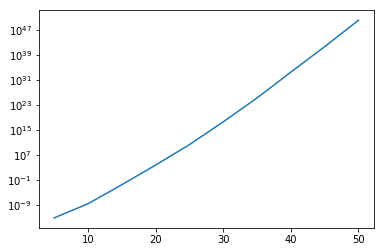

In [7]:
# Define the function
def cat_can():
    nvec = np.arange(5,55,5)
    x = sy.Symbol('x')
    err = []
    for n in nvec:
        sym_integral = sy.integrate((x**n) * sy.exp(x - 1), (x, 0, 1))
        num_integral = ((-1)**n) * sy.subfactorial(n) + ((-1)**(n + 1)) * (sy.factorial(n) / np.exp(1))
        err.append(abs(sym_integral - num_integral) / abs(sym_integral))
    plt.plot(nvec, err)
    plt.yscale('log')

# Call the function
cat_can()

This is not a stable way for computing the integral as the error increases exponentially with n. For n=50 the error value reaches to the tune of 10^47!!!